## LeNet-5

最广为人知的CNN架构，用Yann LeCun 1998年创建，被广泛应用于手写数字识别

著名的 **LeNet-5** 具有如下层次结构：

| 层   | 类型   | 特征图数（Maps） | 空间尺寸（Size） | 卷积核大小（Kernel size） | 步幅（Stride） | 激活函数 |
| --- | ---- |-----------:|-----------| ------------------ | ---------: | ---- |
| Out | 全连接  |          - | 10        | –                  |          – | RBF  |
| F6  | 全连接  |          - | 84        | –                  |          – | tanh |
| C5  | 卷积   |        120 | 1×1       | 5×5                |          1 | tanh |
| S4  | 平均池化 |         16 | 5×5       | 2×2                |          2 | tanh |
| C3  | 卷积   |         16 | 10×10     | 5×5                |          1 | tanh |
| S2  | 平均池化 |          6 | 14×14     | 2×2                |          2 | tanh |
| C1  | 卷积   |          6 | 28×28     | 5×5                |          1 | tanh |
| In  | 输入   |          1 | 32×32     | –                  |          – | –    |

**一些细节补充说明：**

* MNIST 原图为 28×28，但在送入网络前会**零填充到 32×32** 并做归一化。此后网络其余部分**不使用 padding**，所以特征图尺寸会逐层减小。
* 平均池化层稍有不同：每个神经元先对感受野（卷积核）做**均值**，再乘以**可学习的系数**（每个特征图一个），并加上**可学习的偏置**（每个特征图一个），最后再通过激活函数。
* 在 C3 中，大多数神经元**并非与 S2 的全部 6 个特征图完全连接**，而是只连接其中的 3～4 个
* 输出层较特别：并非做常规的加权和，而是让每个输出单元给出**输入向量与其权向量的欧氏距离平方**，衡量图像属于某一数字类别的程度。如今更常用**交叉熵损失**，因为它对错误预测的惩罚更强，梯度更大、收敛更快。


## ResNet

何凯明(Kaiming He)等人使用残差网络(ResNet)赢得了ILSVRC 2015挑战赛，其前五位错误率低于3.6%。获胜的变体使用了由152层组成的非常深的CNN（其他变体具有34、50和101层）。它证实了一个趋势：计算机视觉模型变得越来越深，参数越来越少（层数多了，但每层的参数少了）。训练这种深层网络的关键是使用跳过连接(skip connection)［也称为快捷连接(shortcut connection)］：输入层的信号也将添加到位于堆叠层上方的层的输出中。

在训练神经网络时，目标是使其对目标函数h(x)建模。如果将输入x添加到网络的输出（即添加跳过连接），则网络将被迫建模f(x)=h(x)-x而不是h(x)。这称为残差学习

<img alt="残差学习" height="500" src="./images/CNN/p7.png" width="500"/>


当初始化一个常规神经网络时，它的权重接近于零，所以网络只输出接近于零的值。如果添加跳过连接，生成的网络只会输出其输入的副本。换句话说，它最初对恒等函数建模。如果目标函数非常接近恒等函数，这将大大加快训练速度。

另一种理解方式：如果 h(x) 本来就和 x 很接近，那么 h(x)-x 接近 零函数，网络参数在0附近只需稍微调整即可，大大简化了学习任务。当目标函数接近恒等函数时，网络实际上在做“残差修正”，而不是从零学习复杂的映射。

此外，如果添加许多跳过连接，即使有几个层尚未开始学习，网络也可以开始取得进展。由于跳过连接，信号可以轻松地穿过整个网络。深度残差网络可以看作残差单元(RU)的堆叠，其中每个残差单元都是一个带有跳过连接的小型神经网络。

<img alt="常规的深度神经网络 vs 深度残差网络" height="500" src="./images/CNN/p8.png" width="500"/>

ResNet架构非常简单，开头部分是输入，卷积和最大池化层

中间只是一堆非常深的残差单元。每个残差单元由两个卷积层（没有池化层）组成，具有批量归一化(BN)机制和ReLU激活函数，使用3×3核并保留空间维度（步幅1，"same"填充）。

结尾是全局平均池化（Global Average Pooling），全连接层，以及最后softmax激活的输出层。全局平均池化层把每个通道的特征图直接取平均值，变成一个数字，最后会输出长度为通道数的向量，可以取代一个全连接层，大幅减少参数

![ResNet架构](./images/CNN/p9.png)

注意，特征图的数量每隔几个残差单元就增加一倍，同时高度和宽度减半（使用步幅为2的卷积层）。当发生这种情况时，输入不能直接添加到残差单元的输出，因为它们的形状不同（此问题会影响图中虚线箭头所表示的跳过连接）。为了解决这个问题，输入将通过步幅为2且具有正确数量的输出特征图的1×1卷积层

![改变图大小和深度的跳过连接](./images/CNN/p10.png)

该架构存在不同的变体，它们具有不同的层数。ResNet-34是一个具有34层（仅计算带参数的卷积层和全连接层）的ResNet，它包含3个输出64个特征图的RU、4个输出128个特征图的RU、6个输出256个特征图的RU，以及3个输出512个特征图的RU。

更深的ResNet（例如ResNet-152）使用的残差单元略有不同。它们使用3个卷积层代替了2个具有256个特征图的3×3卷积层：第一个是1×1卷积层，仅具有64个特征图（减少为原来的四分之一），它充当了瓶颈层；然后是一个3×3卷积层，具有64个特征图；最后是另一个1×1卷积层，具有256个特征图（4乘以64），它恢复了原始深度。ResNet-152包含3个此类RU（可输出256个特征图）、8个具有512个特征图的RU、36个具有1024个特征图的RU，以及3个具有2048个特征图的RU。

瓶颈层的作用：“先压缩再恢复”，在保证模型表达力的同时，大幅降低参数量和计算量，使超深的 ResNet（50/101/152）变得可训练。

### 使用Keras实现ResNet-34 CNN

In [3]:
from functools import partial
import tensorflow as tf

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal", use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)

        self.activation = tf.keras.activations.get(activation)

        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]

        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]  # 跳过层只有在strides>1的时候才需要

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)

        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


def make_start(inputs):
    Z = DefaultConv2D(64, kernel_size=7, strides=2)(inputs)
    Z = tf.keras.layers.BatchNormalization(axis=3)(Z)
    Z = tf.keras.layers.Activation("relu")(Z)
    Z = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(Z)
    return Z


def make_block_with_stride1(inputs, filters):
    Z = DefaultConv2D(filters)(inputs)
    Z = tf.keras.layers.BatchNormalization()(Z)

    Z = tf.keras.layers.ReLU()(Z)
    Z = DefaultConv2D(filters)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)

    Z = tf.keras.layers.Add()([Z, inputs])
    output = tf.keras.layers.ReLU()(Z)
    return output

def make_block_with_stride2(inputs, filters):
    # residual
    Z = DefaultConv2D(filters, strides=2)(inputs)
    Z = tf.keras.layers.BatchNormalization()(Z)

    Z = tf.keras.layers.ReLU()(Z)
    Z = DefaultConv2D(filters)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)

    # skip
    Z_skip = DefaultConv2D(filters, kernel_size=1, strides=2)(inputs)
    Z_skip = tf.keras.layers.BatchNormalization()(Z_skip)

    Z = tf.keras.layers.Add()([Z, Z_skip])
    output = tf.keras.layers.ReLU()(Z)
    return output

input_ = tf.keras.layers.Input(shape=(64,64,3))
Z = make_start(input_)

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    if filters == prev_filters:
        Z = make_block_with_stride1(Z, filters)
    else:
        Z = make_block_with_stride2(Z, filters)
    prev_filters = filters # 更新上一个滤波器刷零

Z = tf.keras.layers.GlobalAvgPool2D()(Z)
Z = tf.keras.layers.Flatten()(Z)
output = tf.keras.layers.Dense(6, activation="softmax")(Z)
#
my_resnet34_model = tf.keras.models.Model(input_, output)

In [6]:
# 有了残差单元（RU）后，用Sequential模型来构建ResNet-34，把每个残差单元视为一个层
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[64, 64, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")
])



prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    # 代码唯一有点绕的部分：3个RU有64个滤波器，4个RU有128个滤波器，6个RU有256个滤波器，3个RU有512个滤波器
    # 当滤波器的数量与之前的RU相同时，必须将步幅设置为1，否则将其设置为2
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters # 更新上一个滤波器刷零

model.add(tf.keras.layers.GlobalAvgPool2D())  # 注意全局平均这个层是keras自带的，
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(6, activation="softmax"))

### 练习

把ResNet-34 CNN，并应用于手势识别，看看效果

In [4]:
import h5py
import numpy as np

def load_signs_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

In [5]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [7]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test))

Epoch 1/5
34/34 [==============================] - 37s 839ms/step - loss: 1.1229 - accuracy: 0.5796 - val_loss: 4664.9790 - val_accuracy: 0.1667
Epoch 2/5
34/34 [==============================] - 31s 904ms/step - loss: 0.4585 - accuracy: 0.8407 - val_loss: 448.9229 - val_accuracy: 0.1667
Epoch 3/5
34/34 [==============================] - 31s 910ms/step - loss: 0.2172 - accuracy: 0.9315 - val_loss: 47.2939 - val_accuracy: 0.1667
Epoch 4/5
34/34 [==============================] - 32s 955ms/step - loss: 0.1628 - accuracy: 0.9426 - val_loss: 14.5697 - val_accuracy: 0.1667
Epoch 5/5
34/34 [==============================] - 34s 1000ms/step - loss: 0.1713 - accuracy: 0.9352 - val_loss: 18.0100 - val_accuracy: 0.1583


## Inception

- 核心思想

Inception 的核心是 **“不必预先选一个卷积核尺寸，而是同时尝试多种尺寸，然后把结果拼接（concatenate）起来，让网络自己学习用哪种尺度的特征”**。
也就是在同一位置同时做 1×1、3×3、5×5 的卷积，以及池化，然后把这些输出在通道维度上拼接，得到一个更丰富的多尺度表示。

![Inception模块](./images/CNN/p13.png)

---

- 模块结构与细节

假设输入是 `28 × 28 × 192`：

* 同时计算：

  * 1×1 卷积 → 输出 `28 × 28 × 64`
  * 3×3 卷积（同样用 same padding）→ 输出 `28 × 28 × 128`
  * 5×5 卷积（same padding）→ 输出 `28 × 28 × 32`
  * 池化（stride=1, same padding）→ 输出 `28 × 28 × 32`
* 把四个输出在通道上拼接，得到 `28 × 28 × (64+128+32+32)=28 × 28 × 256`。

> 注意：为了能拼接，所有分支的 **空间尺寸（height, width）必须一致**，因此对池化也用 `padding="same"` 且 `stride=1`，使输出仍为 28×28。



- 为什么不用直接把所有卷积都堆起来？——计算量问题 & 1×1 瓶颈

直接在高通道输入上做大卷积（比如 5×5）代价很高。

* 直接对 `28×28×192` 做 5×5、输出 `28×28×32`，需要的乘法次数约 **120 million**（120M），非常昂贵。
* 解决思路：先用 **1×1 卷积** 把通道从 192 压缩到一个小的通道数（比如 16），再在这个小通道上做 5×5 卷积。

  * 1×1 卷积（192 → 16）的运算约 **2.4M**
  * 在 16 通道上做 5×5（得到 32 通道）的运算约 **10M**
  * 总和约 **12.4M**，比 120M 小约 10 倍。

这个 1×1 的“压缩”层通常被称为 **bottleneck（瓶颈）层**，既节省计算，又保留表达能力。


- 优点

* **多尺度特征**：局部（1×1）、小尺度（3×3）、大尺度（5×5）以及池化的特征都保留，网络可自适应选择不同尺度的组合。
* **计算高效**：通过 1×1 瓶颈层大幅降低后续大卷积的计算量，从而能在可接受的算力下使用“做多种卷积”的策略。
* **模块化**：把该模块堆叠起来就构成 Inception 网络，可以增加深度且控制计算量。


- 实践上的注意点

* 池化分支要用 `padding="same"` 且 `stride=1`（不是常规的降采样池化），以便拼接。
* 瓶颈的通道数是调优项：太小可能损失信息，太大则损失计算优势。
* Inception 是工程取向很强的设计（追求在精度和计算/参数之间的折中），后来有很多变体（Inception-v2/v3 等）继续改进瓶颈和 factorization（把 3×3 分解成两个 1×3 + 3×1 等）。

- 总结

Inception 就是“把多种尺度的卷积和池化并行起来，然后拼接输出；为了解决计算开销，用 1×1 卷积作瓶颈压缩通道”，从而在保持表达力的同时控制计算量。

In [4]:
import tensorflow as tf


def inception_module(x, f1, f3reduce, f3, f5reduce, f5, pool_proj):
    # x: 输入张量
    # f1: 1x1 分支输出通道
    # f3reduce: 3x3 分支之前 1x1 压缩通道
    # f3: 3x3 卷积输出通道
    # f5reduce: 5x5 分支之前 1x1 压缩通道
    # f5: 5x5 卷积输出通道
    # pool_proj: 池化后 1x1 压缩输出通道

    branch1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)

    branch3 = tf.keras.layers.Conv2D(f3reduce, (1,1), padding='same', activation='relu')(x)
    branch3 = tf.keras.layers.Conv2D(f3, (3,3), padding='same', activation='relu')(branch3)

    branch5 = tf.keras.layers.Conv2D(f5reduce, (1,1), padding='same', activation='relu')(x)
    branch5 = tf.keras.layers.Conv2D(f5, (5,5), padding='same', activation='relu')(branch5)

    branch_pool = tf.keras.layers.MaxPooling2D((3,3), strides=1, padding='same')(x)
    branch_pool = tf.keras.layers.Conv2D(pool_proj, (1,1), padding='same', activation='relu')(branch_pool)

    out = tf.keras.layers.Concatenate(axis=-1)([branch1, branch3, branch5, branch_pool])
    return out

# 示例用法：
inputs = tf.keras.Input(shape=(28,28,192))
x = inception_module(inputs, f1=64, f3reduce=96, f3=128, f5reduce=16, f5=32, pool_proj=32)
print(x.shape)  # -> (None, 28, 28, 256)

(None, 28, 28, 256)


### Inception 架构

- 概览

带有 **Inception 模块** 的网络（典型代表：GoogLeNet / Inception）就是把若干个**并行多尺度分支**（1×1、3×3、5×5、pool→1×1）作为基本单元反复堆叠，在中间通过**下采样/Pooling**改变空间分辨率，并在中后层加入\*\*辅助分类器（side branches）\*\*以帮助训练与正则化。最终以全局平均池化 + 全连接（softmax）作为输出头。

---

- 架构分块（从低到高层次）

1. **Stem（输入处理层）**

   * 若干个常规卷积 + 池化，用来把原始图像降到较小的空间分辨率并升通道，为后续模块做准备。

2. **Inception Module（基本模块）**

   * 并行分支：

     * `1×1` 卷积（直接通道混合/压缩）
     * `1×1 -> 3×3`（先降维再做 3×3）
     * `1×1 -> 5×5`（先降维再做 5×5）
     * `3×3 pooling (stride=1, padding='same') -> 1×1`（保留空间尺寸并压缩通道）
   * 把各分支的输出在通道维拼接（concatenate）。
   * 示例：`28×28×192` → 一模块 → `28×28×256`。

3. **Pooling (池化层）**

   * 若干 Inception 模块之间用 MaxPool / Conv(stride=2) 降采样以减小 H×W

4. **Auxiliary Classifiers（辅助分类器 / 侧支）**

   * 在中间若干层接出一个小的分类头（小 conv -> FC -> softmax）。
   * 作用：增强中间层梯度流、起到正则化效果、加速训练收敛。

5. **Final Head（最终输出）**

   * 最末端常用 GlobalAveragePooling -> Dropout -> Dense(softmax)。
   * 全局平均替代了大量 FC 参数，使得参数量大幅下降（更轻量且鲁棒）。


## MobileNet

MobileNet是结构更简洁，运行更高效的深度卷积网络模型，旨在变得轻量级和快速，在计算能力有限的设备中，也能运行深度学习模型

- MobileNet降低计算开销的解决方案：深度可分离卷积（Depthwise Separable Convolution）
1. 传统卷积：6 * 6 * 3 -> 4 * 4 * 5, 乘法数量： 27 * 4 * 4 * 5 = 2160
2. 深度可分离卷积拆分为2步：第一步是Depthwise Convolution（逐通道卷积），每个通道单独做卷积，互不混合： 6 * 6 * 3 -> 4 * 4 * 3的乘法数量：9 * 4 * 4 * 3 = 432，第二步是Pointwise Convolution（逐点卷积，1×1 卷积），把所有通道重新组合，做跨通道的特征融合，4 * 4 * 3 -> 4 * 4 * 5的乘法数量：3 * 4 * 4 * 5 = 240， 432 + 240 = 672， 672/2160 大概为0.3
3. 所以通过把传统卷积，拆分为2个步骤，计算量显著降低； 符号推导它能省下多少计算量：

输入：n×n×n_c
输出：n×n×n_c'（假设 SAME padding、stride=1，使空间尺寸保持为 n）
卷积核：f×f

一、普通卷积（standard conv）
每个输出通道使用一个 f×f×n_c 卷积核
每个位置乘法数：f^2 · n_c
位置个数：n^2
输出通道数：n_c'
总乘法数：
Mult_std = n^2 · f^2 · n_c · n_c'

二、深度可分离卷积（Depthwise + Pointwise）

(1) Depthwise（逐通道卷积）
每个输入通道使用一个 f×f 卷积核（不混通道）
每个位置乘法数：f^2
位置个数：n^2
通道数：n_c
乘法数：
Mult_dw = n^2 · f^2 · n_c

(2) Pointwise（逐点 1×1 卷积）
1×1×n_c 卷积核做通道融合，产生 n_c' 个输出通道
每个位置乘法数：n_c
位置个数：n^2
输出通道数：n_c'
乘法数：
Mult_pw = n^2 · n_c · n_c'

合计（深度可分离）：
Mult_DS = Mult_dw + Mult_pw = n^2 · n_c · (f^2 + n_c')

三、计算量比值（节省比例）
Mult_DS / Mult_std
= [n^2 · n_c · (f^2 + n_c')] / [n^2 · f^2 · n_c · n_c']
= 1/n_c' + 1/f^2

典型设定：f=3 且 n_c' 很大（如 256~512），1/n_c' 很小，主导项为 1/9，故深度可分离卷积乘法量约为普通卷积的 ~1/9。

MobileNet v1 架构

1. **基本模块**

   * 每个标准卷积都替换成：

     * **Depthwise Convolution（逐通道卷积）**：每个通道单独提取空间特征；
     * **Pointwise Convolution（1×1 卷积）**：跨通道融合特征。

2. **堆叠方式**

   * v1 中堆叠了 **13 个这样的深度可分离卷积块**，从输入图像逐步提取特征。

3. **尾部结构**

   * **Pooling → 全连接层 → Softmax**，完成分类任务。

4. **效果**

   * 与普通卷积相比，计算量降低至约 **1/8 \~ 1/9**，在移动设备上表现良好。

---

<img alt="MobileNet v1 vs MobileNet v2" height="600" src="./images/CNN/p11.png" width="600"/>

MobileNet v2 在 v1 基础上做了两大改进：

1. **残差连接（Residual/Skip Connection）**

   * 借鉴 ResNet，使梯度更容易反向传播，训练更稳定。

2. **瓶颈块（Bottleneck Block）**

<img alt="MobileNet v2瓶颈块" height="600" src="./images/CNN/p12.png" width="600"/>

   * 结构：
     * **扩展层（Expansion，1×1 卷积）**：把通道数放大，例如扩展 6 倍，提升表达能力；
     * **Depthwise 卷积**：在扩展后的通道上提取空间特征；
     * **投影层（Projection，1×1 卷积）**：把通道数压回较小值，减少存储和传递的内存开销；
     * **残差相加**：若输入输出维度相同，直接跳连。
   * 好处：
     * **扩展 → 学习更复杂特征**；
     * **投影 → 控制内存和计算**；
     * **残差 → 稳定梯度**。

3. **网络规模**

   * v2 使用这种瓶颈块堆叠 **17 次**，再接上 Pooling → FC → Softmax 做分类。

---

总结

* **MobileNet v1**：用 **Depthwise + Pointwise** 替代普通卷积 → 高效轻量。
* **MobileNet v2**：在 v1 基础上增加 **残差连接 + 扩展/投影瓶颈块** → 更强的表达力，更高的精度。
* **适用场景**：移动端、IoT、边缘计算、需要低延迟推理的场合。

## 使用Keras的预训练模型

很多经典模型架构无需用代码重新实现，因为在tf.keras.applications包中只需要一行代码就可以轻松获得预训练的网络

In [17]:
import matplotlib.pyplot as plt
import numpy as np


In [7]:
# 加载 RestNet-50 模型
import tensorflow as tf
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 707s 7us/step


上面代码创建一个ResNet-50模型并下载在ImageNet数据集上预先训练的权重。要使用它，首先需要确保图像尺寸合适。ResNet-50模型需要224×224像素的图像（其他模型可能需要其他尺寸，例如299×299像素），所以使用Keras的Resizing层调整两个样本图像的大小（在将它们裁剪到目标纵横比之后）

In [4]:
from sklearn.datasets import load_sample_images
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True)(images)

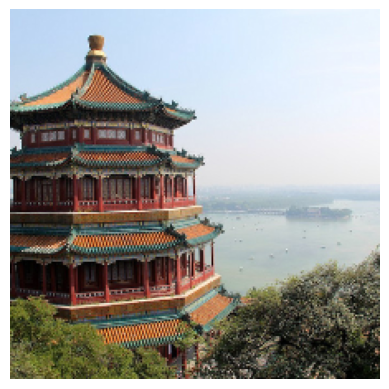

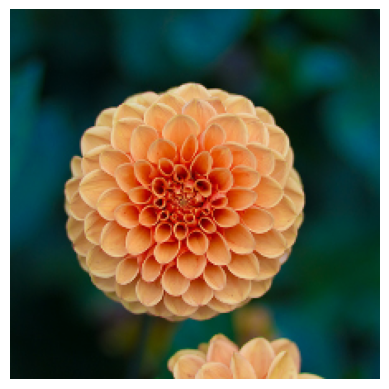

In [5]:
for x in image_resized:
    # print(x.numpy().shape)
    plt.imshow(x.numpy() / 255.)
    plt.axis('off')
    plt.show()

预先训练的模型假定以特定方式对图像进行预处理。在某些情况下，它们可能期望输入缩放到0～1或-1～1。每个模型都提供一个preprocess_input()函数，可以用来预处理图像。这些函数假设原始像素值的范围是0～255

In [6]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

通常，Y_proba输出一个矩阵，每个图像一行，每个类别一列（在这个示例中，共有1000个类别）。如果要显示前K个预测，包括类别名和每个预测类别的估计概率，使用decode_predictions()函数。对于每个图像，它返回一个包含前K个预测的数组，其中每个预测都表示为一个包含类别标识符、其名称和对应置信度得分的数组

In [7]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 1s 1s/step


(2, 1000)

In [8]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 [==============================] - 0s 7us/step
Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


正确的类别是宫殿(palace)和大丽花(dahlia)，因此模型对于第一幅图像的预测是正确的，但对于第二幅图像的预测是错误的。那是因为大丽花不是1000个ImageNet类别之一。

使用预训练模型创建非常好的图像分类器非常容易,tf.keras.applications中提供了许多其他视觉模型，从轻量级快速模型到大型精确模型不等。

但是，如果想对不属于ImageNet的图像类别使用图像分类器,仍然可以通过预训练模型执行迁移学习来从中受益。

In [30]:
from PIL import Image
pic = Image.open("images/test_resnet50.jpg")
pic = np.array(pic)

test_images = []
test_images.append(pic)
# test_images = pic

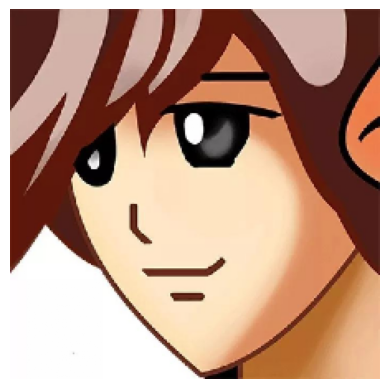

In [32]:
test_images_resized = tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True)(test_images)

for x in test_images_resized:
    # print(x.numpy().shape)
    plt.imshow(x.numpy() / 255.)
    plt.axis('off')
    plt.show()

In [33]:
test_inputs = tf.keras.applications.resnet50.preprocess_input(test_images_resized)

Y_proba_test = model.predict(test_inputs)
Y_proba_test


1/1 [==============================] - 0s 100ms/step


array([[1.79570065e-08, 5.87898761e-08, 5.47648881e-07, 3.05883958e-08,
        1.22053251e-07, 7.20000685e-07, 1.60347270e-07, 9.75699095e-08,
        7.12158581e-08, 5.36799050e-08, 1.51853339e-08, 3.34129282e-07,
        1.44593839e-08, 3.12657953e-08, 3.08971195e-08, 5.78399089e-08,
        9.09697462e-07, 5.18067054e-07, 1.10330411e-07, 3.39003989e-08,
        4.23449009e-09, 2.64407277e-07, 3.76105227e-08, 4.49979360e-08,
        1.62245129e-07, 2.19122740e-07, 3.94183303e-07, 1.20870827e-05,
        5.47978765e-08, 2.69227964e-08, 3.56224961e-09, 1.66130913e-08,
        8.73640644e-08, 1.61341465e-08, 1.82320406e-07, 1.04156717e-09,
        1.07876510e-07, 2.05838031e-08, 4.92719209e-07, 2.60050346e-08,
        5.78960112e-07, 6.30173744e-08, 4.39223733e-08, 3.27454245e-07,
        3.03251859e-08, 1.16691943e-07, 1.58904658e-08, 3.46469022e-07,
        1.35744767e-08, 1.08652074e-08, 1.65114038e-08, 1.25286188e-05,
        1.98440645e-07, 1.39247641e-06, 1.23490036e-08, 2.720110

In [21]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba_test, top=3)

# for class_id, name, y_proba in top_K[image_index]:
#         print(f"  {class_id} - {name:12s} {y_proba:.2%}")
top_K

35363/35363 [==============================] - 0s 8us/step


[[('n03590841', "jack-o'-lantern", 0.5707659),
  ('n03724870', 'mask', 0.28670532),
  ('n04192698', 'shield', 0.06397602)]]

In [22]:
top_K

[[('n03590841', "jack-o'-lantern", 0.5707659),
  ('n03724870', 'mask', 0.28670532),
  ('n04192698', 'shield', 0.06397602)]]

## 使用预训练模型进行迁移学习

如果想构建一个图像分类器，但没有足够的数据从头开始训练它，那么重用预训练模型的较低层通常是个好办法，例如，来训练模型对花的图片进行分类，并使用预先训练的Xception模型。

首先，用TensorFlow数据集加载花的数据集：

In [10]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True) # with_info=True获得有关数据集的信息 （大小和类的名称）
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [11]:
# 拆分训练集，将数据集的前10%用于测试，接下来的15%用于验证，剩下的75%用于训练

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

这3个数据集都包含单独的图像。需要对它们进行批处理，但首先需要确保它们都具有相同的大小，否则批处理将失败。为此，可以使用Resizing层。还必须调用tf.keras.applications.xception.preprocess_input()函数为Xception模型适当地预处理图像。最后，还将打乱训练集并预取样本：

In [12]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

NameError: name 'plt' is not defined

In [13]:
# 每批包含32个图像，224*224个像素，像素值范围为-1 -- 1
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

In [15]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # 必须将图像重新缩放到 imshow() 的 0-1 范围内，并且
        # 将结果裁剪到该范围内，因为数据增强可能会
        # 使某些值超出范围（例如，本例中的 RandomContrast）
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")
plt.show()

NameError: name 'plt' is not defined

tf.keras.preprocessing.image.ImageDataGenerator类可以轻松地从磁盘加载图像并以各种方式增强它们：你可以偏移每幅图像，旋转它、重新缩放它、水平或垂直翻转它、剪切它或应用想应用的变换函数。这对于简单的项目来说非常方便。但是，tf.data流水线并不复杂，而且通常速更快。此外，如果有GPU并且模型中包含预处理或数据增强层，它们将在训练期间受益于GPU加速。

In [16]:
import tensorflow as tf

In [17]:
# 加载一个在ImageNet上预训练过的Xception模型。 通过设置include_top=False来排除网络顶部的层。这会排除全局平均池化层和密集输出层。
# 然后，使用softmax激活函数添加自己的全局平均池化层（将基础模型的输出提供给它），再添加一个密集输出层（每个类别一个单元）。最后，将所有这些包装在Keras Model中：
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)  # include_top=False → 模型输出是最后一层卷积特征图 (batch_size, h, w, channels)。 这样可以自己决定是接 GAP(全局平均池化）、Flatten，再接上自己的 Dense 分类层。
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)


model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [18]:
# 冻结预训练的权重

for layer in base_model.layers:
    layer.trainable = False

# base_model.trainable=False # 如果模型直接使用base model的层，而不是base model对象本身，设置base_model.trainable=False无效

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 88s 1s/step - loss: 0.7400 - accuracy: 0.8070 - val_loss: 0.6922 - val_accuracy: 0.8367
Epoch 2/3
86/86 [==============================] - 88s 1s/step - loss: 0.3204 - accuracy: 0.9073 - val_loss: 0.5606 - val_accuracy: 0.8748
Epoch 3/3
86/86 [==============================] - 89s 1s/step - loss: 0.1969 - accuracy: 0.9393 - val_loss: 0.5473 - val_accuracy: 0.8639


In [20]:
# 模型经过几轮训练后，验证精度不在提高后，可以解冻基础模型的一些层，然后继续训练

for layer in base_model.layers[56:]:
    layer.trainable = True

In [21]:
# 每当冻结或解冻层时，要编译模型；
# 还要确保使用低得多的学习率以避免破坏预训练的权重
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 281s 3s/step - loss: 0.2720 - accuracy: 0.9081 - val_loss: 0.6031 - val_accuracy: 0.8639
Epoch 2/10
86/86 [==============================] - 274s 3s/step - loss: 0.0626 - accuracy: 0.9815 - val_loss: 0.3959 - val_accuracy: 0.9020
Epoch 3/10
86/86 [==============================] - 273s 3s/step - loss: 0.0148 - accuracy: 0.9949 - val_loss: 0.3354 - val_accuracy: 0.9093
Epoch 4/10
86/86 [==============================] - 273s 3s/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.3220 - val_accuracy: 0.9165
Epoch 5/10
86/86 [==============================] - 273s 3s/step - loss: 0.0149 - accuracy: 0.9960 - val_loss: 0.3523 - val_accuracy: 0.9056
Epoch 6/10
86/86 [==============================] - 302s 4s/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.3105 - val_accuracy: 0.9111
Epoch 7/10
86/86 [==============================] - 280s 3s/step - loss: 0.0044 - accuracy: 0.9982 - val_loss: 0.3394 - val_accuracy: 0.9074
Epoch 8/10
86

In [6]:
model.evaluate(test_set)

NameError: name 'model' is not defined

### 练习

使用MobileNetV2的预训练模型，对花的图片进行分类

## 分类和定位

定位图片中物体可以表示为回归任务：预测物体周围的边界框（一种常见的方法是预测物体中心的水平和垂直坐标，及其高度和宽度）。这意味着有4个数字需要预测。这不需要对模型进行太多修改，只需添加具有4个单元的第二个密集输出层（通常在全局平均池化层之上），就可以使用MSE损失对其进行训练：

In [ ]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)


loc_output = tf.keras.layers.Dense(4)(avg)  # (x,y, 高度，宽度）

model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)  # added this line
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # 取决于更关注分类损失，还是更关注回归损失
              optimizer=optimizer, metrics=["accuracy", "mse"])

但是，花朵数据集中花朵周围没有边界框。因此，需要自己添加它们。这通常是机器学习项目中最难、成本最高的一个部分：获取标签。花时间寻找合适的工具是一个好办法。要使用边界框标注图像，可能需要使用开源图像标记工具（例如VGG ImageAnnotator、LabelImg、OpenLabeler或ImgLab）或者商业工具（例如LabelBox或Supervisely）。如果需要标注大量图像，建立众包平台（百度数据众包），准备发送给工人的表格，对工人进行监督并确保他们给出的边界框的质量良好，这是一项相当繁重的工作，因此要保证这样做是值得的。

即使不打算使用众包。如果只有几千甚至几百幅图像需要标记，而且不打算经常这样做，最好自己做：使用正确的工具，只需几天时间。在此过程中，还能更好地了解数据集和任务。

假设已经获得了花朵数据集中每幅图像的边界框（假设每幅图像有一个边界框），需要创建一个数据集，其数据项将是经过预处理的批量图像，以及它们的类别标签和边界框。每个数据项都应为以下形式的元组：(images，(class_labels，bounding_boxes))。然后，就可以训练模型了

应该对边界框进行归一化，以便水平和垂直坐标以及高度和宽度都在0～1的范围内。而且通常要预测高度和宽度的平方根，而不是直接的高度和宽度值：通过这种方式，大边界框的10像素误差将不会像小边界框的10像素误差一样受到惩罚。MSE通常作为代价函数可以很好地训练模型，但是评估模型对边界框的预测能力时它不是一个很好的指标。最常用的度量指标是“交并比”(Intersection over Union，IoU)：预测边界框和目标边界框之间的重叠面积除以它们的合并面积。在Keras中，它是由tf.keras.metrics.MeanIoU类实现的。

![边界框的交并比（IoU)指标](./images/CNN/p14.png)

In [2]:
# 加个随机边框训练
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

## 物体检测

对图像中的多个物体进行分类和定位的任务称为物体检测。曾经一种常见的方法是采用经过训练的CNN对图像中大致居中的单个物体进行分类和定位，然后将该CNN滑过图像并在每一步进行预测。通常，要训练CNN不仅可以预测类别概率和边界框，还可以预测存在性得分(objectness score)：这是图像确实包含以中间为中心的物体的估计概率。这是一个二元分类输出，它可以由具有单个单元的密集输出层（使用sigmoid激活函数并使用二元交叉熵损失进行训练）产生。

有时不使用存在性得分，反而会添加一个“无物体”类别，但总的来说，这种方法效果不太好：最好将“是否存在物体？”和“物体的类型是什么？”这两个问题分开回答。

这种滑动CNN的方法如下图所示。在这个示例中，图像被切割成5×7的网格，我们看到CNN（黑色粗矩形）在所有3×3的区域上滑动，并在每一步进行预测。

![在图像上滑动CNN检测多个物体](./images/CNN/p15.png)

在此过程中，CNN已经对其中三个3×3区域进行了预测：

- 当查看左上角的3×3区域（以位于第二行第二列的红色网格单元格为中心）时，它检测到图像左边的玫瑰。请注意，预测的边界框超出了这个3×3区域的边界。这绝对没问题：尽管CNN看不到玫瑰的底部，但它能够对它可能的位置做出合理的预测。它还预测到类别标签，给出了“玫瑰”类别的高置信度。最后，它预测到了相当高的存在性得分，因为边界框的中心位于中央单元格内（在此图中，存在性得分由边界框的颜色深度表示）。

- 当查看下一个3×3区域时，框架一个单元格（以蓝色网格单元格为中心的灰框），它没有检测到任何似乎位于该区域中心的玫瑰，因此它预测了一个非常低的存在性得分。因此，可以安全地忽略预测的边界框和类别预测。可以看到预测的边界框无论如何都不对齐。

- 最后，当查看当前黑框的3×3区域时，同样框起一个单元格（以绿色网格单元格为中心的黑框），它在顶端检测到玫瑰，尽管并不完美。这朵玫瑰实际上没有很好地位于该区域的中心，所以预测的存在性得分不是很高。

可以想象整个模型在整个图像上滑动CNN总共会输出15个预测的边界框，每个边界框伴随着估计的类别预测和存在性得分。由于物体有不同的大小，你可能需要多个CNN滑动窗口的大小（比如4×4区域），以获得良好的检测结果。

这种技术相当简单，但却有局限。它通常会在图像的不同位置多次检测到一个物体。需要进行一些后处理来移除不必要的边界框。一种常见的方法称为非极大抑制（non-max suppression），它已经这样工作的：

1. 首先，选择所有存在性得分低于某个阈值的边界框：由于CNN从头到尾滑动位置很多次，因此边界框是无用的。
2. 找到具有最高存在性得分的边界框，并去掉所有与它显著重叠的框（例如，IoU大于60%）。例如，在图中，具有最高存在性得分的边界框是最大的玫瑰边界框。所有与它有很大重叠的另外一些边界框就会被移除（尽管存在性得分已经在上一步被缩减掉了）。
3. 重复步骤2，直到没有显著重叠的边界框需要删除。

NMS 就像在朋友圈选照片：

一次旅行拍了 20 张同一个人的照片（好多框）。 不会全发，而是挑出最清晰、最好看的一张（最高分的框）。其他长得差不多的重复照片就删掉了（重叠框去掉）。

这种简单的物体检测方法效果很好，但是需要多次运行CNN（在本例中为15次），因此速度很慢。幸运的是，有一种更快的方法可以在图像上滑动CNN：使用全卷积网络（FCN）。


### 全卷积网络

FCN(全卷积网络）的概念在2015年发表的论文首次提出，主要用于语义分割（根据图像所属物体的类别对图像中的每个像素进行分类的任务）。作者指出，可以用卷积层代替CNN顶部的密集层。为了解这一点，来看一个示例：

假设一个具有200个神经元的密集层位于一个卷积层的顶部，该卷积层输出100个特征图，每个特征图的大小为7×7（这是特征图的大小，不是核大小）。每个神经元将计算来自卷积层的所有100×7×7激活的加权和（加上偏差项）。

现在，看看如果使用200个滤波器（每个滤波器的大小为7×7）并使用"valid"填充将卷积层替换为密集层，会发生什么情况。该层将输出200个特征图，每个特征图大小为1×1（因为核大小正好是输入特征图的大小，并且使用的是"valid"填充）。换句话说，它将输出200个数字，就像密集层一样。如果仔细观察卷积层执行的计算，你会发现这些数字与密集层产生的数字完全相同。唯一的区别是，密集层的输出是形状为［批量大小，200］的张量，而卷积层将输出形状为［批量大小，1，1，200］的张量。要将密集层转换为卷积层，卷积层中的滤波器数必须等于密集层中的单元数，滤波器大小必须等于输入特征图的大小，并且必须使用"valid"填充。步幅可以设置为1或更大。

为什么要把密集层改成卷积层？ 密集层需要特定的输入大小（因为每个输入特征只有一个权重），但卷积层可以愉快地处理任何大小的图像，只希望其输入具有特定数量的通道，因为每个核为每个输入通道包含一组不同的权重）。由于FCN仅包含卷积层（以及具有相同属性的池化层），因此可以在任何大小的图像上对其进行训练和执行！例如，假设我们已经训练了一个用于花卉分类和定位的CNN。它在224×224的图像上进行训练，并输出10个数字：
- 输出0到4通过softmax激活函数发送，这给出了类别概率（每个类别一个）。
- 输出5通过sigmoid激活函数发送，这给出了存在性得分。
- 输出6和7表示边界框的中心坐标，它们还通过sigmoid激活函数来确保它们的范围为0～1。
- 最后，输出8和9表示边界框的高度和宽度，它们不通过任何激活函数来允许边界框超出图像的边界。

现在可以将CNN的密集层转换为卷积层。事实上，甚至不需要重新训练它，只需将权重从密集层复制到卷积层！或者，可以在训练前将CNN转换为FCN。现在假设当网络被馈送入一个224×224图像时，输出层之前的最后一个卷积层（也称为瓶颈层）输出7×7特征图。如果向FCN提供448×448的图像，则瓶颈层将输出14×14的特征图。由于密集输出层已被卷积层替换，并且卷积层使用了10个大小为7×7的滤波器，填充为"valid"且步幅为1，因此卷积层输出将由10个特征图组成，每个特征图的大小为8×8（因为14-7+1=8）。换句话说，FCN将只处理一次整个图像，并且将输出一个8×8的网格，每个单元格包含10个数字（5个类别概率、1个存在性得分和4个边界框坐标）。这就像将一个原始的CNN以每行8步、每列8步的方式在图像上滑动一样。为了可视化这一过程，想象一下将原始图像多个卷积+池化层 降采样成14×14的网格，然后在该网格上滑动7×7的窗口。该窗口将有8×8=64个可能的位置，因此有8×8个预测结果。但是，由于网络只查看一次图像，因此FCN方法效率更高

![相同的全卷积网络处理小图像和大图像](./images/CNN/p16.png)


## YOLO